In [1]:
import pandas as pd
import numpy as np
from bcb import sgs
from bcb import currency
from bcb import Expectativas
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#### Buscando SELIC

In [2]:
selic = sgs.get({'selic' : 432}, start = '2010-01-01')

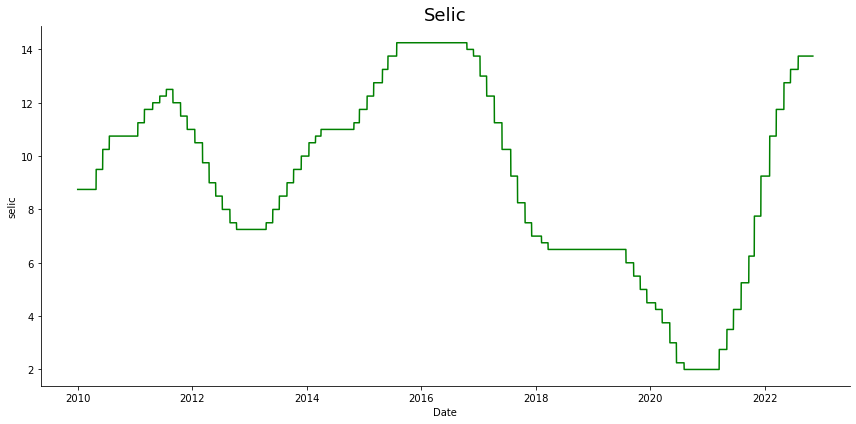

In [3]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.lineplot(data = selic, x = 'Date', y = 'selic', color = 'green')
ax.set_title('Selic', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
plt.show();

#### Inflacao

In [4]:
inflacao = sgs.get({'ipca' : 433, 'igp-m' : 189}, start = '2010-01-01')

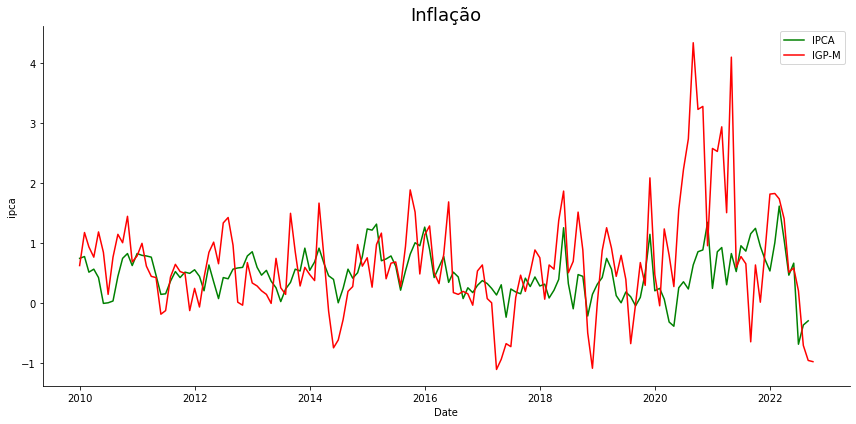

In [5]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.lineplot(data = inflacao, x = 'Date', y = 'ipca', color = 'green', label = 'IPCA')
sns.lineplot(data = inflacao, x = 'Date', y = 'igp-m', color = 'red', label = 'IGP-M')
ax.set_title('Inflação', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
plt.show();

#### Moedas

In [6]:
df_moedas = currency.get_currency_list()
df_moedas.head(4)

,code,name,symbol,country_code,country_name,type,exclusion_date
0,5,AFEGANE AFEGANIST,AFN,132,AFEGANISTAO ...,A,NaT
1,785,RANDE/AFRICA SUL,ZAR,7560,AFRICA DO SUL ...,A,NaT
2,490,LEK ALBANIA REP,ALL,175,"ALBANIA, REPUBLICA DA ...",A,NaT
3,610,MARCO ALEMAO,DEM,230,ALEMANHA ...,A,2002-01-02


In [7]:
hoje = datetime.date.today()

In [8]:
moedas = currency.get(['USD', 'EUR', 'GBP'], start = '2010-01-01', end = hoje)

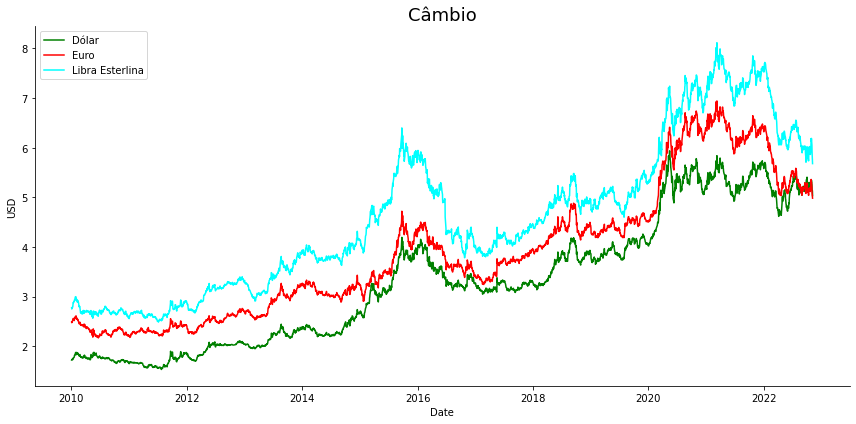

In [9]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.lineplot(data = moedas, x = 'Date', y = 'USD', color = 'green', label = 'Dólar')
sns.lineplot(data = moedas, x = 'Date', y = 'EUR', color = 'red', label = 'Euro')
sns.lineplot(data = moedas, x = 'Date', y = 'GBP', color = 'cyan', label = 'Libra Esterlina')
ax.set_title('Câmbio', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
plt.show();

#### Expectativas

ExpectativasMercadoTrimestrais:
- PIB Total
- PIB Agropecuária
- PIB Indústria
- PIB Serviços
- Taxa de desocupação
- IPCA
- Câmbio

ExpectativasMercadoTop5Mensais

In [10]:
expec = Expectativas()
expec.describe()

EntitySets:
  ExpectativasMercadoTop5Anuais
  ExpectativasMercadoInstituicoes
  ExpectativaMercadoMensais
  ExpectativasMercadoInflacao12Meses
  ExpectativasMercadoSelic
  ExpectativasMercadoTop5Selic
  ExpectativasMercadoTop5Mensais
  ExpectativasMercadoTrimestrais
  ExpectativasMercadoAnuais


##### Funcoes auxiliares

In [11]:
def obtendo_expectativas(indicador):
    ep = expec.get_endpoint('ExpectativasMercadoTrimestrais')
    df_ep = ep.query().filter(ep.Indicador == indicador).collect()
    df_ep = df_ep[df_ep['Data'] >= '2022']
    
    return df_ep

In [12]:
def unindo_prev(x):
    
    # Filtrando para previsoes dos ultimos 3 meses
    tres_meses = datetime.date.today() - datetime.timedelta(days = 90)
    tres_meses = tres_meses.strftime('%Y-%m-%d')
    
    # Selecionando trimestres
    trimestres = ['3/2022', '4/2022', '1/2023', '2/2023', '3/2023', '4/2023']
    
    # Calculando as metricas
    dicio_metricas = {}
    df_aux = x.copy()
    for trimestre in trimestres:
        df_aux = x[(x['DataReferencia'] == trimestre) & (x['Data'] > tres_meses)]
        dicio_metricas['media_{}'.format(trimestre)] = df_aux['Media'].mean()
        dicio_metricas['mediana_{}'.format(trimestre)] = df_aux['Mediana'].mean()
    
    # Colocando em um dataframe
    df = pd.DataFrame(list(dicio_metricas.items()))
    df.columns = ['metrica_trimestre', 'valor']
    df[['metrica', 'trimestres']] = df['metrica_trimestre'].str.split('_', 1, expand = True)
    df = df.drop(columns = 'metrica_trimestre')
    df = df[['trimestres', 'metrica', 'valor']]
    
    return df

#### Obtendo Expectativas do PIB

In [13]:
pib_total = obtendo_expectativas('PIB Total')
df_previsoes_pib = unindo_prev(pib_total)

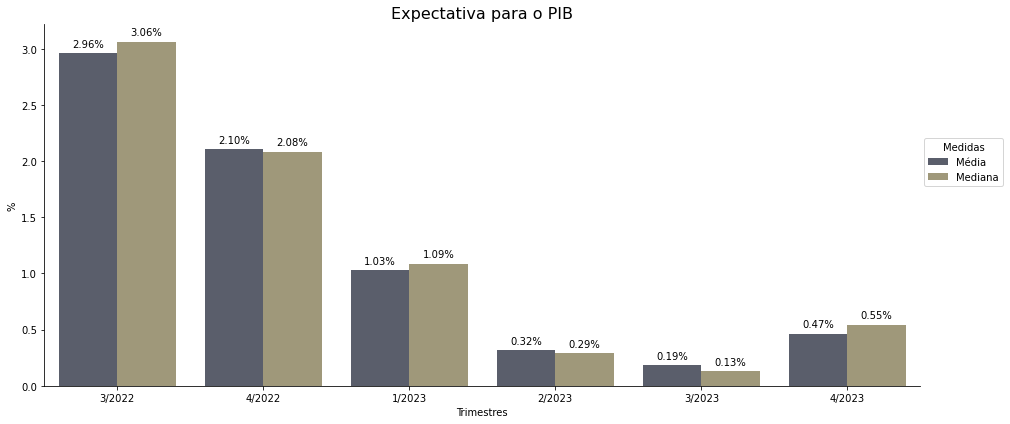

In [14]:
fig, ax = plt.subplots(figsize = (14, 6))

sns.barplot(data = df_previsoes_pib, x = 'trimestres', y = 'valor', hue = 'metrica', palette = 'cividis')
ax.set_title('Expectativa para o PIB', fontsize = 16)
handles, labels = ax.get_legend_handles_labels()
labels = ['Média', 'Mediana']
ax.set_xlabel('Trimestres')
ax.set_ylabel('%')
ax.legend(title = 'Medidas', handles = handles, labels = labels, bbox_to_anchor = [1.1, 0.7, 0, 0])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for container in ax.containers:
    ax.bar_label(container, fmt = '%.2f%%', padding = 4)

fig.tight_layout()
plt.show();

#### Obtendo dados de expectativa para o IPCA

In [15]:
previsao_ipca = obtendo_expectativas('IPCA')
df_previsoes_ipca = unindo_prev(previsao_ipca)

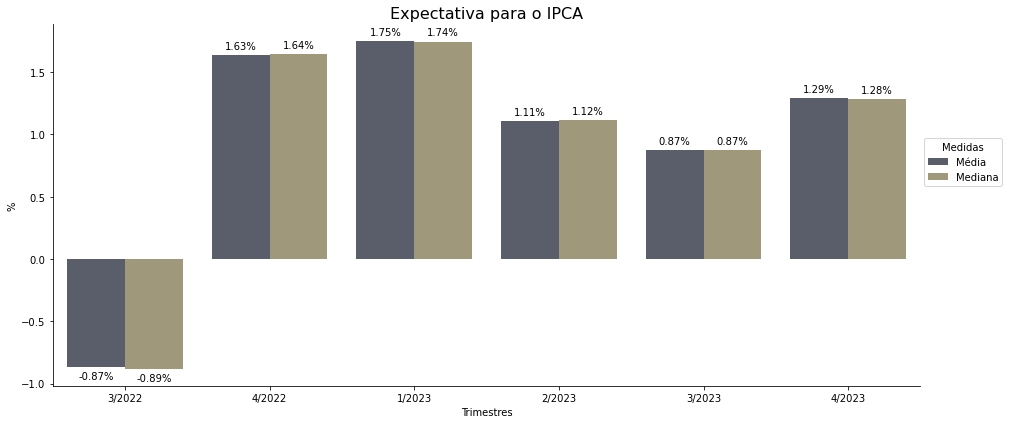

In [16]:
fig, ax = plt.subplots(figsize = (14, 6))

sns.barplot(data = df_previsoes_ipca, x = 'trimestres', y = 'valor', hue = 'metrica', palette = 'cividis')
ax.set_title('Expectativa para o IPCA', fontsize = 16)
handles, labels = ax.get_legend_handles_labels()
labels = ['Média', 'Mediana']
ax.set_xlabel('Trimestres')
ax.set_ylabel('%')
ax.legend(title = 'Medidas', handles = handles, labels = labels, bbox_to_anchor = [1.1, 0.7, 0, 0])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for container in ax.containers:
    ax.bar_label(container, fmt = '%.2f%%', padding = 4)

fig.tight_layout()
plt.show();

#### Obtendo expectativas para o cambio: Dolar

In [17]:
previsao_cambio = obtendo_expectativas('Câmbio')
df_previsoes_cambio = unindo_prev(previsao_cambio)

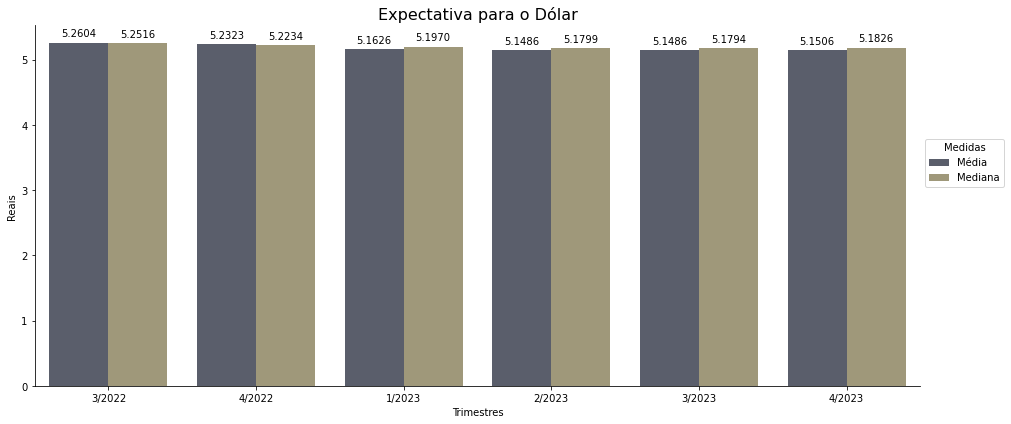

In [18]:
fig, ax = plt.subplots(figsize = (14, 6))

sns.barplot(data = df_previsoes_cambio, x = 'trimestres', y = 'valor', hue = 'metrica', palette = 'cividis')
ax.set_title('Expectativa para o Dólar', fontsize = 16)
handles, labels = ax.get_legend_handles_labels()
labels = ['Média', 'Mediana']
ax.set_xlabel('Trimestres')
ax.set_ylabel('Reais')
ax.legend(title = 'Medidas', handles = handles, labels = labels, bbox_to_anchor = [1.1, 0.7, 0, 0])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for container in ax.containers:
    ax.bar_label(container, fmt = '%.4f', padding = 4)
    
fig.tight_layout()
plt.show();

#### Obtendo expectativas para o cambio: Taxa de Desocupação

In [31]:
previsao_desocupacao = obtendo_expectativas('Taxa de desocupação')
df_previsoes_desocupacao = unindo_prev(previsao_desocupacao)

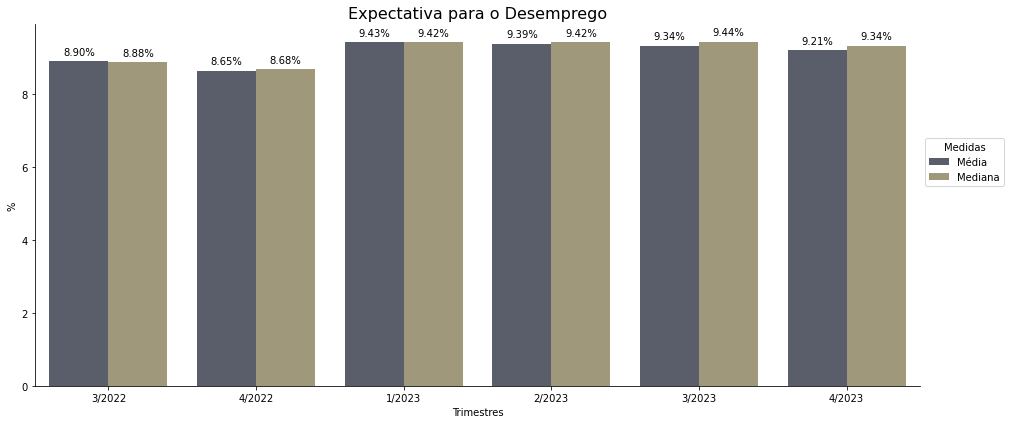

In [36]:
fig, ax = plt.subplots(figsize = (14, 6))

sns.barplot(data = df_previsoes_desocupacao, x = 'trimestres', y = 'valor', hue = 'metrica', palette = 'cividis')
ax.set_title('Expectativa para o Desemprego', fontsize = 16)
handles, labels = ax.get_legend_handles_labels()
labels = ['Média', 'Mediana']
ax.set_xlabel('Trimestres')
ax.set_ylabel('%')
ax.legend(title = 'Medidas', handles = handles, labels = labels, bbox_to_anchor = [1.1, 0.7, 0, 0])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for container in ax.containers:
    ax.bar_label(container, fmt = '%.2f%%', padding = 4)
    
fig.tight_layout()
plt.show();